In [27]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt

In [76]:
# Download latest Covid 19 data
df = pd.read_csv("https://covid.ourworldindata.org/data/ecdc/full_data.csv")

# Downloaded population from World Bank
# http://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=csv
pop = pd.read_csv("population.csv", skiprows=4)
pop = pop.set_index('Country Name')
pop = pop['2018'].dropna()

In [77]:
# Default values
values_def = 'new_cases'
since_def = '2020-03-01'
countries_def=['Italy','Spain','United Kingdom','Ireland','China','United States','Iran']

# Set the default size for the figures
plt.rcParams["figure.figsize"] = (14, 10)

In [78]:
# @global df - data frame containing Covid 19 data by date and by country
# @global pop - data frome containing population data from 2018
# @param values - one of 'new cases', 'total cases', 'new deaths', total deaths'
# @param since - show data only for dates since this date; format 'yyyy-mm-dd'
# @param countries - show data only for the specified countries
# @param by_pop - set to True to divide numbers by population per country, in millions
def covid(values=values_def, since=since_def, countries=countries_def, by_pop=False):
    # filter by date
    df2 = df[df.date >= since]
    # generate a pivot chart
    piv = df2.pivot(index='date', columns='location', values=values)
    # filter by country
    if (countries == []):
        sub = piv.drop(columns='World')
    else:
        sub = piv[countries]
    # setup title of plot
    title=values + " since " + since
    if (by_pop):
        # divide each number by the population, in millions
        pop2 = pop[countries]
        pop2 = pop2/1e6
        pop2 = pop2.transpose()
        sub = sub/pop2.values
        title = title + " per million of population"
    # sort
    lastrow=sub.shape[0]-1
    lastrow_name=sub.index[lastrow]
    sub.sort_values(by=lastrow_name,axis=1,ascending=False,inplace=True)
    return sub, title

C:\Users\Brian\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


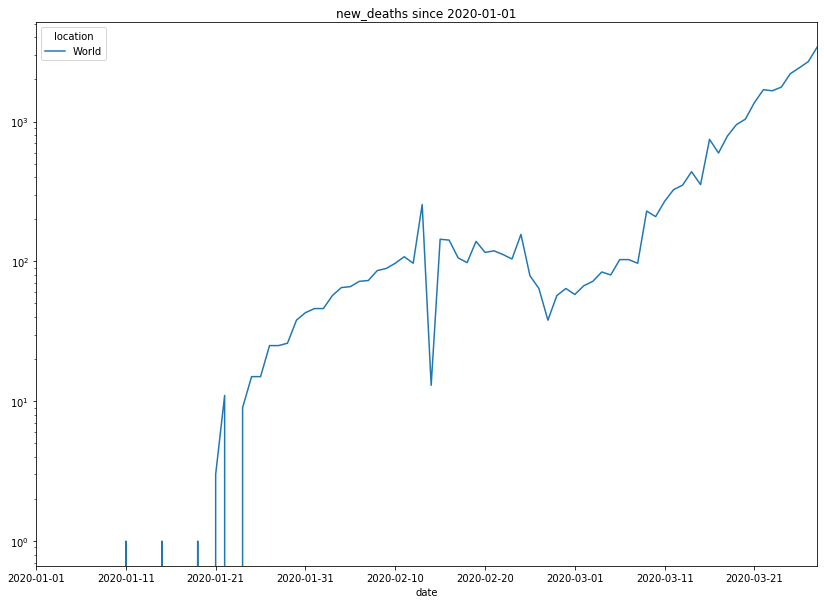

In [79]:
sub, title = covid(values='new_deaths',countries=['World'],since='2020-01-01')
sub.plot(title=title,logy=True)

In [80]:
# generate the sub-pivot for all countries in the covid dataframe
sub, title=covid(countries=[])

# not all countries in the covid dataframe are also in the population dataframe
# find the intersection of these two sets
countries_inter=pop.index.intersection(sub.columns)

# note, can also find the union and difference between the union and the intersection
# if you want to see what countries are being omitted
countries_union=pop.index.union(sub.columns)
countries_diff=countries_union.difference(countries_inter)

C:\Users\Brian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  del sys.path[0]
C:\Users\Brian\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


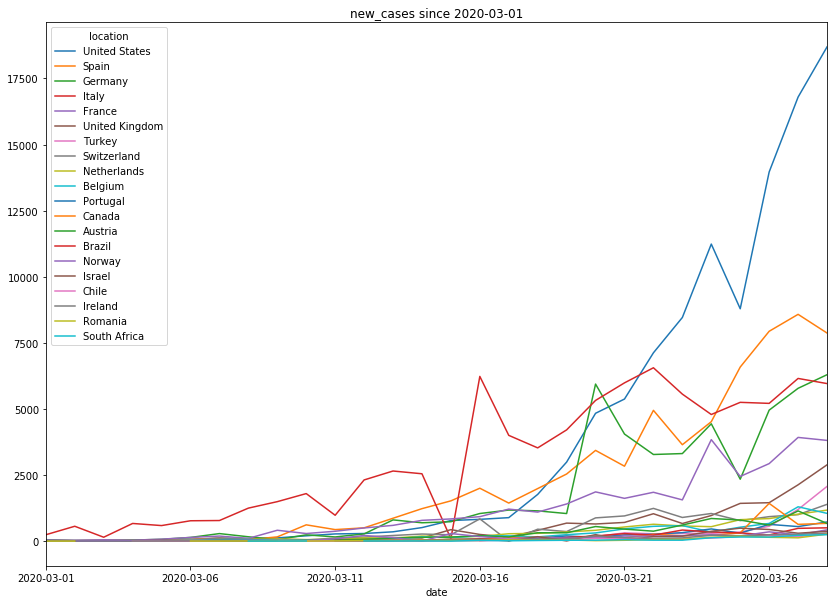

In [81]:
# look at top 20 countries
sub, title = covid(countries=countries_inter.values)
sub = sub.iloc[:,:20]
sub.plot(title=title,logy=False)

C:\Users\Brian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  del sys.path[0]


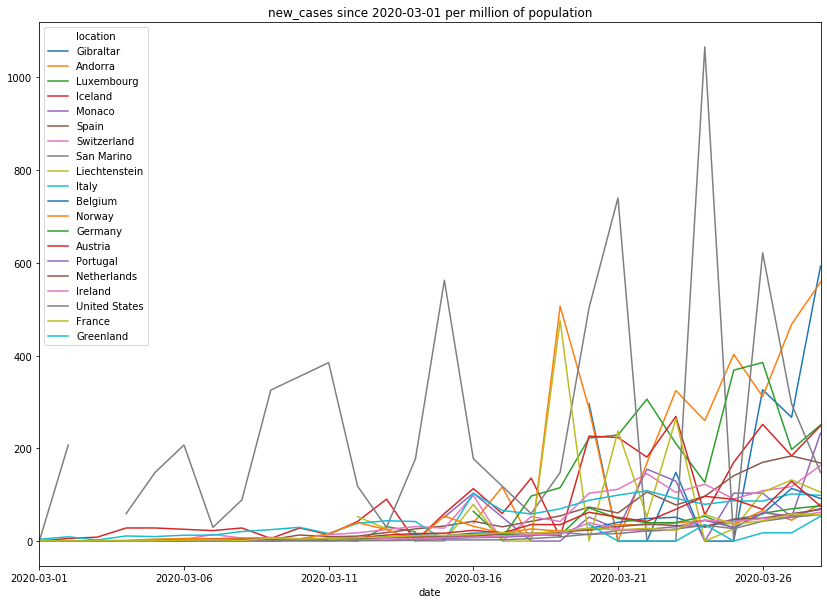

In [82]:
# look at top 20 countries, by population
sub, title = covid(countries=countries_inter.values, by_pop=True)
sub = sub.iloc[:,:20]
sub.plot(title=title,logy=False)

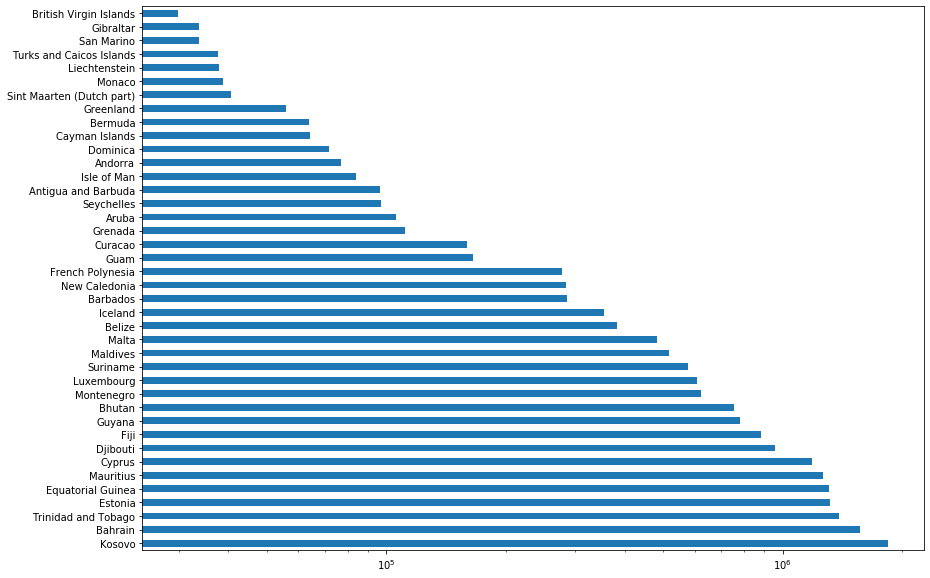

In [83]:
# Countries with smaller populations are showing up - let's look at 40 countries with the smallest population
pop2=pop[countries_inter].sort_values(ascending=False).dropna()
entries=pop2.shape[0]
pop2.iloc[entries-40:].plot(kind='barh',logx=True)

In [84]:
# Let's only consider countries with population greater than 1m
countries_small = pop2[pop2.values <= 1e6]
countries_large = countries_inter.difference(countries_small.index)

C:\Users\Brian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  del sys.path[0]


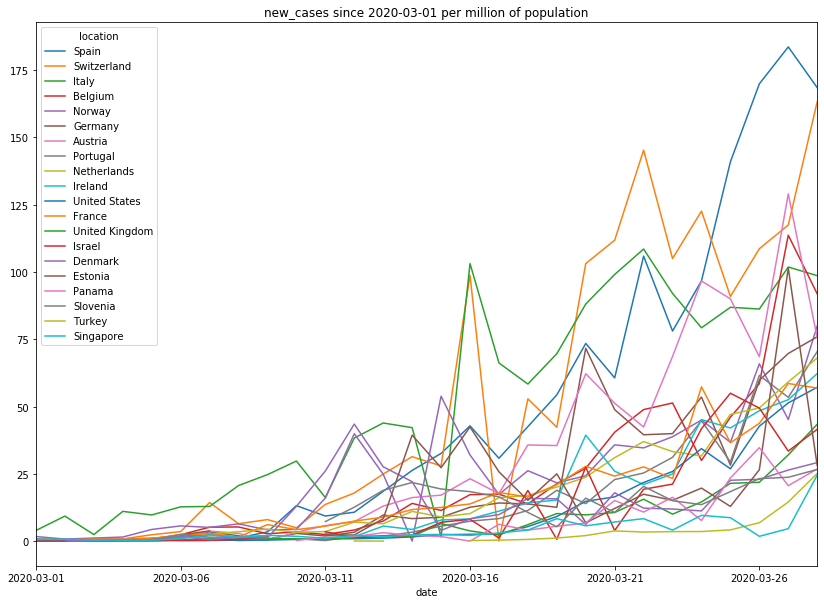

In [85]:
# look at top 20 countries, by population
sub, title = covid(countries=countries_large.values, by_pop=True)
sub = sub.iloc[:,:20]
sub.plot(title=title,logy=False)